> ### EEE4423: Deep Learning Lab

# LAB \#4: Limitation: Spatial Transformer Network(STN)

In [344]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-03-27 06:49:35.762741


## Spatial Transformer Network for classification of distorted MNIST dataset

## Spatial Transformer Network(STN) [1]
>- CNNs are limited by the lack of ability to be spatially invariant to the input data
>- Learnable module which explicitly allows the spatial manipulation of data within the network
>- This differentiable module can be inserted into existing convolutional architectures

<img src="http://drive.google.com/uc?export=view&id=1GV2Ix6wuikWdq6-tGkZv2vMQbqMokDbf" alt="no_image" style="width: 900px;"/>

### STN module
>1. Localization Network
>>- With given input feature map, this network outputs the parameters of the spatial transformation (e.g. 6 parameters for affine transformation)
>>- Reference for affine transformation : [2],[3] <br>
>> <img src="http://drive.google.com/uc?export=view&id=1qho08Gzea5qDTpmsnii0rvwiLzwy54K6" alt="no_image" style="width: 900px;"/>

>2. Parameterised sampling grid (Grid generator)
>>- Set of points where the input feature map is sampled to produce the transformation which is a output of localization network  
>>- Target coordinate and source coordinate are normalised ($ -1\le(x_i^t, y_i^t)\le1$,$ -1\le(x_i^s, y_i^s)\le1$ )
<img src="http://drive.google.com/uc?export=view&id=1pRWzwevo1KjWi3WIC4K8SCkK4oYCD7FZ" alt="no_image" style="width: 500px;"/>
>3. Differentiable Image Sampling (Sampler)
>>- Ouput feature map is produced by differentiable bilinear interpolation with input feature map and parameterised sampling grid
    
<img src="http://drive.google.com/uc?export=view&id=1EjoZ6CVLTD3QNl1CKbg1w3YiNf1CzOmH" alt="no_image" style="width: 900px;"/>


In [3]:
import warnings
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.utils as v_utils
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import io
import requests
import os 
import copy
import time
%matplotlib inline

warnings.filterwarnings("ignore")

In [4]:
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [5]:
# parameters

batch_size = 256
learning_rate = 0.001
num_epoch = 60
num_classes = 10

### 1. Dataset (Distorted MNIST, details in Appendix A.4 Distorted MNIST) [1point]
>- Generate RTS(rotated, translated, scaled) MNIST 
>>- Use *torchvision.transforms*
>>- Randomly rotating between $-45^\circ, 45^\circ$
>>- Randomly scaling the digit by a factor of between $0.7,1.2$
>>- Placing the digit in a random location in a $40\times40$ region of image's center
>>- Zerp padding to increase image's size for the digit's translation ($80\times80$ image)
>>- Images to tensor 
>>- Normalize data with MNIST dataset's mean and standard deviation printed in the 5th cell below


#### 1.1 Write codes for dataset's transformation [1 point]


In [353]:
print('STEP 1: DEFINE DATASET')

# CenterCrop -> 80x80(zeropadded)
# Random affine : scale, rotation and tranlsation
# - translation = (1/4, 1/4) -> make -20 < dx(dy) < 20

    
distortion = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((80,80)),
    transforms.RandomAffine(degrees = (-45,45), translate = (0.25,0.25),scale=(0.7,1.2),fill =0 ),    
    transforms.Normalize(mean = 0.1307, std = 0.3081),
])

train_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=True, 
                        #############
                        # CODE HERE #
                        #############
                        transform = distortion,
                        target_transform=None,
                        download=True)
test_dataset = dset.MNIST(root='../dataset/lab04/MNIST', train=False, 
                        #############
                        # CODE HERE #
                        #############
                        transform = distortion,
                        target_transform=None,
                        download=False)


train_size = len(train_dataset)
test_size = len(test_dataset)

#dataset mean and std for normalization
print('MNIST mean: ',train_dataset.train_data.float().mean()/255)
print('MNIST std: ',train_dataset.train_data.float().std()/255)

STEP 1: DEFINE DATASET
MNIST mean:  tensor(0.1307)
MNIST std:  tensor(0.3081)


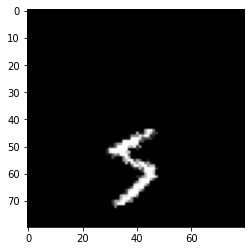

In [354]:
x= train_dataset[0][0].permute(1,2,
                               0)
plt.imshow(x,cmap ='gray')

In [355]:
print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))

Train dataset size: 60000
Test dataset size: 10000


###  Visualize Dataset


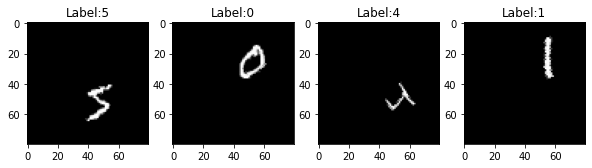

In [356]:
figure = plt.figure(figsize= (10,5))

for i in range(train_size):
    sample = train_dataset[i]
    figure.add_subplot(1,4,i+1).set_title('Label:{}'.format(sample[1]))
    imgplot = plt.imshow((sample[0].squeeze(0).cpu()+1)/2,cmap = 'gray')
    if i == 3:
        plt.show()
        break

In [357]:
print('STEP 2: LOADING DATASET')

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=4,drop_last=True)

STEP 2: LOADING DATASET


##  Model
### 2. CNN Model Setup (details in Appendix A.4 Distorted MNIST) [3points]
>
>1. CNN 
>>- 2 convolutional layers and 2 max-pooling layers before final classification layer
>>- Two conv layers have 32 and 64 filters and use ReLU 
>2. Classifier
>>- 2 fully-connected layers and the number of input features to the last layer is 128
>>- Also use ReLU as an activation function
>3. ST module
>>- At the beginning of the network
>>- 2 convolutional layer and 2 fully-connected layer in localization network
>>- Initialize the *fc_loc*'s final regression layer with identity transformation
>>- Produce affine transformation parameters for RTS dataset
>>- Reference for grid generator function: [4] <br>
>>- Reference for sampler function: [5] <br>
>
> **++Hint: All learnable parameters' sizes of model are in the 10th cell below** <br>
> **++For RTS datasets, the network has average pooling layer after the ST module to downsample the output of the transformer by a factor of 2**

| **Layer** | **Kernel size** | **stride** | **padding** |
|:---:|:---:|:---:|:---:|
| 1st Conv of *cnn* | 9 | 1 | 0 |
| 2nd Conv of *cnn* | 7 | 1 | 0 |
| 1st Conv of *localization* | 5 | 1 | 0 |
| 2nd Conv of *localization* | 5 | 1 | 0 |
| AvgPool | 2 | 2 | 0 |
| MaxPool | 2 | 2 | 0 |


#### 2.1 Write codes for the model class (STN_CNN) [3 points]


In [6]:
print('STEP 3: CREATE MODEL CLASS (STN_CNN)')

#############
# CODE HERE #
#############

class STN_CNN(nn.Module):
    def __init__(self):
        super(STN_CNN,self).__init__()
        self.cnn = nn.Sequential(
            nn.AvgPool2d(2,2), #avg pool after ST module 80x80 -> 40
            nn.Conv2d(1, 32,9), # 40 -> 32
            nn.MaxPool2d(2,2), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(32,64,7), # 16 ->10
            nn.MaxPool2d(2,2),  # 10 -> 5
            nn.ReLU()            
        )
        
        self.classifier = nn.Sequential(
            nn.Linear( 1600 ,128), # 5x5x64 = 1600 -> 128
            nn.ReLU(),
            nn.Linear(128,10)
        )
      
        self.localization = nn.Sequential(
            nn.Conv2d(1, 20, 5), # 80 -> 76
            nn.MaxPool2d(2,2),   # 76 -> 38, 2x downsample (details in paper's appendix A.4)
            nn.ReLU(),
            nn.Conv2d(20,20,5), # 38 -> 34?
            nn.ReLU()
        )
        
        self.fc_loc = nn.Sequential(
            # initialize fc_loc's final regerssion layer with identitty 
            nn.Linear(23120,20),
            nn.ReLU(),
            nn.Linear(20,6)
        )
                
        # Initialization
        # final regression layer of localisation networks which are initialised to regress the identity transform (zero weights, identity transform bias)
        nn.init.zeros_(self.fc_loc[-1].weight)
        self.fc_loc[-1].bias = nn.Parameter(torch.tensor([1,0,0,0,1,0],dtype = torch.float32))
        
        # transform parameter
        self.theta = torch.eye(2,3).view(1,2,3)
    
    # Spatial Transformer Module
    def ST_module(self,x):
        out = self.localization(x).view(-1,23120)
        out = self.fc_loc(out).view(-1,2,3)   # loclization network
        self.theta = out
        out = nn.functional.affine_grid(theta = out, size= torch.Size((x.shape[0],1,80,80))) # grid generator: to 80x80
        out = nn.functional.grid_sample(x, out)    # Sampler
        return out
    
        
    def forward(self, x):
        out = model.ST_module(x)
        # CNN
        out = self.cnn(out).view(-1, 1600)
        # Classifier
        out= self.classifier(out)
        return out

STEP 3: CREATE MODEL CLASS (STN_CNN)


In [359]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


In [360]:
print('STEP 4: INSTANTIATE MODEL CLASS\n')
model = STN_CNN()

print("STN_CNN's state_dict:")
os.makedirs('weights/lab04', exist_ok=True)
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

STEP 4: INSTANTIATE MODEL CLASS

STN_CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])
localization.0.weight 	 torch.Size([20, 1, 5, 5])
localization.0.bias 	 torch.Size([20])
localization.3.weight 	 torch.Size([20, 20, 5, 5])
localization.3.bias 	 torch.Size([20])
fc_loc.0.weight 	 torch.Size([20, 23120])
fc_loc.0.bias 	 torch.Size([20])
fc_loc.2.weight 	 torch.Size([6, 20])
fc_loc.2.bias 	 torch.Size([6])


###  Parameter updates
#### Scheduling (Annealing) the learning rate [6]
>- In training deep networks, it is usually helpful to anneal the learning rate over time
>>- With high learning rate, the optimizing system can't settle down into deeper parts of the loss function
>- When to decay can be tricky
>>- Slowly : Wasting computation with little improvement for a long time
>>- Aggressively: Cooling too quickly, unable to find the best point
>- 3 common types
>>1. Step decay: Reduce the learning rate by some factor every few epochs (e.g. half every 5 epochs, or by 0.1 every 10 epochs)
>>2. Exponential decay: In the form of mathematical formulation $\alpha = \alpha_0\exp^{-kt}$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number(or units of epochs)
>>3. $1/t$ decay : In the form of mathematical formulation $\alpha = \alpha_0/(1+kt)$, where $\alpha_0, k$ are hyperparameters and $t$ is the iteration number
>- In practice, the step decay is slightly preferable

#### How to adjust learning rate in pytorch [7]
>- *torch.optim.lr_scheduler* provides several methods based on the number of epochs
>- For example, the step decay can be implemented by *torch.optim.lr_scheduler.StepLR* class (See reference for more types)
>- We use *ReduceLROnPlateau* class in this lab which allows dynamic learning rate adjusting based on our validation measurements
>>- Reduce the learning rate when our metric has stopped improving 
>>- The learning rate is reduced if no improvement of our metric is seen for a 'patience' number of epochs
>>- See reference for more details 


In [361]:
print('STEP 5: INSTANTIATE OPTIMIZER CLASS')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

STEP 5: INSTANTIATE OPTIMIZER CLASS


### 3.Train/Test [2points]


#### 3.1Tirain the STN_CNN model and print accuracy for every epochs [2 points]


In [387]:
print('STEP 6: INSTANTIATE LOSS CLASS')
#############
# CODE HERE #
#############


# Loss
criterion = nn.CrossEntropyLoss()

# Model to GPU
model.to(device0)

print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        #############
        # CODE HERE #
        #############
        img, label = img.to(device0), label.to(device0)
        
        optimizer.zero_grad()
        
        pred = model(img)
        
        loss = criterion(pred, label)
        
        loss.backward()
        
        optimizer.step()
        
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model.eval()
    #############
    # CODE HERE #
    #############
    # accuracy for whole data
    total_num = 0
    correct_num = 0
    loss_test = []
    with torch.no_grad():        
        for j, (img, label) in enumerate(test_loader):
            img, label = img.to(device0), label.to(device0)

            pred = model(img)
            loss_test.append(criterion(pred, label))
            
            total_num += len(img) 
            correct_num += (label == pred.max(1).indices).sum()
    # test accuracy
    accuracy = 100*correct_num / total_num
    
    print('Train Epoch: {} [Test Loss: {:.8f}  /  Test accruacy: {:.2f}%]  '.format(epoch, sum(loss_test)/len(loss_test),accuracy ))   
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_STN.tar')
       
        best_acc = accuracy
    
    scheduler.step(accuracy)

STEP 6: INSTANTIATE LOSS CLASS
STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:1e-05]	Loss:0.054090  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:1e-05]	Loss:0.027072  
Train Epoch: 0 [Test Loss: 0.03153951  /  Test accruacy: 99.04%]  
////Epoch elapsed time: 20.098234176635742////

Train Epoch: 1 [0/60000 (0%) / Learning rate:1e-05]	Loss:0.022335  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:1e-05]	Loss:0.011492  
Train Epoch: 1 [Test Loss: 0.03750153  /  Test accruacy: 98.98%]  
////Epoch elapsed time: 19.124221086502075////

Train Epoch: 2 [0/60000 (0%) / Learning rate:1e-05]	Loss:0.044660  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:1e-05]	Loss:0.010373  
Train Epoch: 2 [Test Loss: 0.03556532  /  Test accruacy: 98.84%]  
////Epoch elapsed time: 18.791836500167847////

Train Epoch: 3 [0/60000 (0%) / Learning rate:1e-05]	Loss:0.024684  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:1e-05]	Loss:0.017356  
Train Epoch: 3 [Test Loss: 0.0376152

### 4. Visualize original inputs and transformed inputs with best pre-trained model  [3points]


In [7]:
model = STN_CNN()
checkpoint = torch.load('./weights/lab04/best_model_STN.tar')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

#### Our pretrained model's best accuracy


In [8]:
print('Best accuracy of our model with ST module: ', checkpoint['accuracy'])

Best accuracy of our model with ST module:  tensor(99.1386, device='cuda:0')


In [365]:
# Tensor image to array image
def reprocess_image(img):
    
    img_re = copy.copy(img.cpu().data.numpy())
    
    mean = [-0.1307,-0.1307,-0.1307]
    std = [1/0.3081,1/0.3081,1/0.3081]
    
    for c in range(3):
        img_re[c,:,:] /= std[c]
        img_re[c,:,:] -= mean[c]
        
    img_re[img_re > 1] = 1
    img_re[img_re < 0] = 0
    
    img_re = img_re.transpose(1,2,0)

    return img_re

#### 4.1 Write codes for visualization of original inputsa and transformed inputs [3 points]
>- VisualizeSTN class with an input of our pretrained model
>- *forward_stn*: Forward pass of our pretrained STN module to produce transformed inputs
>- *visualize*: Visualizing the original inputs and the transformed ones in a grid 
>>1. Forward pass of STN module to produce the transformed inputs
>>2. Unnormalize both images using *reprocess_image* function
>>3. Make grids of them 
>>4. Visualize 


In [366]:
class VisualizeSTN():
    def __init__(self, model):
        self.model = model
        self.model.to(device0)
        self.model.eval()
    
    # Output transformed inputs
    def forward_stn(self,x):
        #############
        # CODE HERE #
        #############
        return model.ST_module(x)
        
    def visualize(self, img):
        #############
        # CODE HERE #
        #############
        # transformed image
        img_st = self.forward_stn(img)
#         img, img_st = reprocess_image(img), reprocess_image(img_st)
        # Image- Grid
        row = []
        row_st = []
        # concate in axis = 0 direction
        for i in range(4):
            # original image
            img_split = reprocess_image(img[4*i:4*i+4].squeeze(1))
            row.append(np.concatenate((img_split[:,:,0],img_split[:,:,1],img_split[:,:,2],img_split[:,:,3]),axis=0))
            # transformed image
            img_st_split = reprocess_image(img_st[4*i:4*i+4].squeeze(1))
            row_st.append(np.concatenate((img_st_split[:,:,0],img_st_split[:,:,1],img_st_split[:,:,2],img_st_split[:,:,3]),axis=0))
        # concate in axis=1 direction
        img_grid = np.concatenate((row[0],row[1],row[2],row[3]),axis=1)
        img_st_grid = np.concatenate((row_st[0],row_st[1],row_st[2],row_st[3]), axis =1)
        
        
        # Display Image-Grid 
        fig, ax = plt.subplots(1,2,figsize=(10,10))
        ax[0].imshow(img_grid,cmap = 'gray')
        ax[0].set_title("Original Images")

        ax[1].imshow(img_st_grid, cmap = 'gray')
        ax[1].set_title("Transformed Images")
        

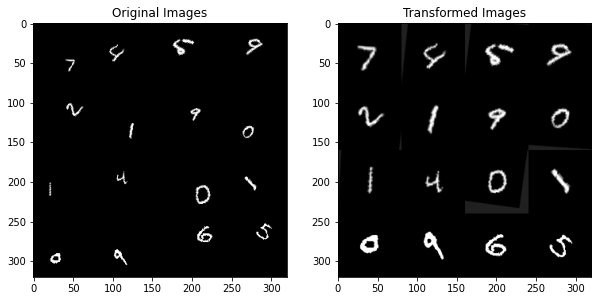

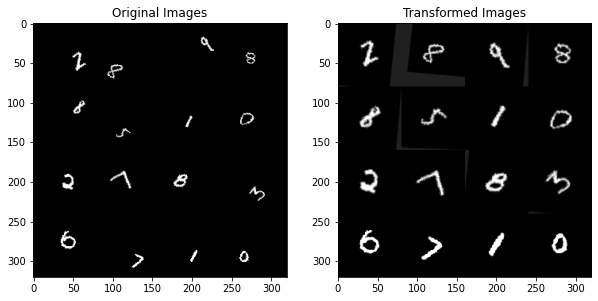

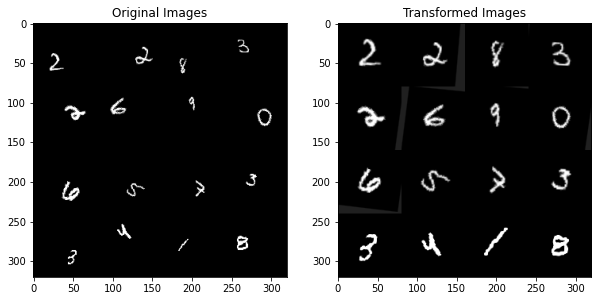

In [367]:
visualize_stn = VisualizeSTN(model)
for i, (image,label) in enumerate(test_loader):
    
    img = image[:16].to(device0)
    visualize_stn.visualize(img)
    
    if (i+1) == 3:
        break

### 5.Comparison with the cnn model without ST module [1point]
>- Model composed of cnn and classifier modules same with our pretrained CNN_STN model 
>- Use *cnn* and *classifier* modules you implemented 


#### 5.1 Write codes for the model class

In [372]:
#############
# CODE HERE #
#############
# deep copy for pretrained layer assignment
import copy

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn = copy.deepcopy(model.cnn)
        
        self.classifier = copy.deepcopy(model.classifier)
        
    def forward(self,x):
        out = self.cnn(x).view(-1,1600)
        out = self.classifier(out)
        return out

In [373]:
model_nostn = CNN()

print("CNN's state_dict:")
for param_tensor in model_nostn.state_dict():
    print(param_tensor, "\t", model_nostn.state_dict()[param_tensor].size())

CNN's state_dict:
cnn.1.weight 	 torch.Size([32, 1, 9, 9])
cnn.1.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([64, 32, 7, 7])
cnn.4.bias 	 torch.Size([64])
classifier.0.weight 	 torch.Size([128, 1600])
classifier.0.bias 	 torch.Size([128])
classifier.2.weight 	 torch.Size([10, 128])
classifier.2.bias 	 torch.Size([10])


In [376]:
optimizer = torch.optim.Adam(model_nostn.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.1, patience=6)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

#### 5.2 Train/Test

In [377]:
#############
# CODE HERE #
#############


# Loss
criterion = nn.CrossEntropyLoss()

# Model to GPU
model_nostn.to(device0)

print('STEP 7: TRAIN THE MODEL')
best_acc = 0

for epoch in range(num_epoch):
    #TRAIN
    model_nostn.train()
    start = time.time()
    
    for j,(img,label) in enumerate(train_loader):
        
        #############
        # CODE HERE #
        #############
        img, label = img.to(device0), label.to(device0)
        
        optimizer.zero_grad()
        
        pred = model_nostn(img)
        
        loss = criterion(pred, label)
        
        loss.backward()
        
        optimizer.step()
        
        if j % 200 == 0:
            
            print('Train Epoch: {} [{}/{} ({:.0f}%) / Learning rate:{}]\tLoss:{:.6f}  '.format(
                    epoch, j * len(img), train_size,
                    100. * j / len(train_loader),get_lr(optimizer), loss.item()))
            
           
                    
    #Test
    model_nostn.eval()
    #############
    # CODE HERE #
    #############
    # accuracy for whole data
    total_num = 0
    correct_num = 0
    loss_test = []
    with torch.no_grad():        
        for j, (img, label) in enumerate(test_loader):
            img, label = img.to(device0), label.to(device0)

            pred = model_nostn(img)
            loss_test.append(criterion(pred, label))
            
            total_num += len(img) 
            correct_num += (label == pred.max(1).indices).sum()
    # test accuracy
    accuracy = 100*correct_num / total_num
    
    print('Train Epoch: {} [Test Loss: {:.8f}  /  Test accruacy: {:.2f}%]  '.format(epoch, sum(loss_test)/len(loss_test),accuracy ))   
    print('////Epoch elapsed time: {}////\n'.format(time.time() - start))  
    
    
    if accuracy > best_acc :
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_nostn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy': accuracy
            
            }, './weights/lab04/best_model_nostn.tar')
       
        best_acc = accuracy
        
    scheduler.step(accuracy)

STEP 7: TRAIN THE MODEL
Train Epoch: 0 [0/60000 (0%) / Learning rate:0.001]	Loss:2.263999  
Train Epoch: 0 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.451728  
Train Epoch: 0 [Test Loss: 0.35094655  /  Test accruacy: 88.68%]  
////Epoch elapsed time: 18.857447385787964////

Train Epoch: 1 [0/60000 (0%) / Learning rate:0.001]	Loss:0.349551  
Train Epoch: 1 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.305120  
Train Epoch: 1 [Test Loss: 0.25825137  /  Test accruacy: 92.12%]  
////Epoch elapsed time: 19.812896728515625////

Train Epoch: 2 [0/60000 (0%) / Learning rate:0.001]	Loss:0.282822  
Train Epoch: 2 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.258529  
Train Epoch: 2 [Test Loss: 0.20650043  /  Test accruacy: 93.34%]  
////Epoch elapsed time: 18.896592378616333////

Train Epoch: 3 [0/60000 (0%) / Learning rate:0.001]	Loss:0.254688  
Train Epoch: 3 [51200/60000 (85%) / Learning rate:0.001]	Loss:0.193018  
Train Epoch: 3 [Test Loss: 0.20380107  /  Test accruacy: 93.51%]  


#### Best accuracy of the model without ST module


In [378]:
print('Best accuracy of our model without ST module: ', best_acc)

Best accuracy of our model without ST module:  tensor(97.8566, device='cuda:0')


![image](./Untitled.png)

### *References*
[1] https://arxiv.org/pdf/1506.02025.pdf <br>
[2] https://en.wikipedia.org/wiki/Affine_transformation <br>
[3] https://en.wikipedia.org/wiki/Transformation_matrix#Affine_transformations <br>
[4] https://pytorch.org/docs/stable/nn.html#affine-grid <br>
[5] https://pytorch.org/docs/stable/nn.html#torch.nn.functional.grid_sample <br>
[6] http://cs231n.github.io/neural-networks-3/#anneal <br>
[7] https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate <br>